In [1]:
import os

In [2]:
# Directory with training chest x-rays
normal_dir = os.path.join(r'E:\chest_xray\train\NORMAL')
abnormal_dir = os.path.join(r'E:\chest_xray\train\PNEUMONIA')

In [4]:
train_normal_chest = os.listdir(normal_dir)
print(train_normal_chest[:5])

train_abnormal_chest = os.listdir(abnormal_dir)
print(train_abnormal_chest[:5])

['IM-0115-0001.jpeg', 'IM-0117-0001.jpeg', 'IM-0119-0001.jpeg', 'IM-0122-0001.jpeg', 'IM-0125-0001.jpeg']
['person1000_bacteria_2931.jpeg', 'person1000_virus_1681.jpeg', 'person1001_bacteria_2932.jpeg', 'person1002_bacteria_2933.jpeg', 'person1003_bacteria_2934.jpeg']


In [5]:
print('total normal images:', len(os.listdir(normal_dir)))
print('total abnormal images:', len(os.listdir(abnormal_dir)))

total normal images: 1341
total abnormal images: 3875


In [6]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

Showing some normal pictures...



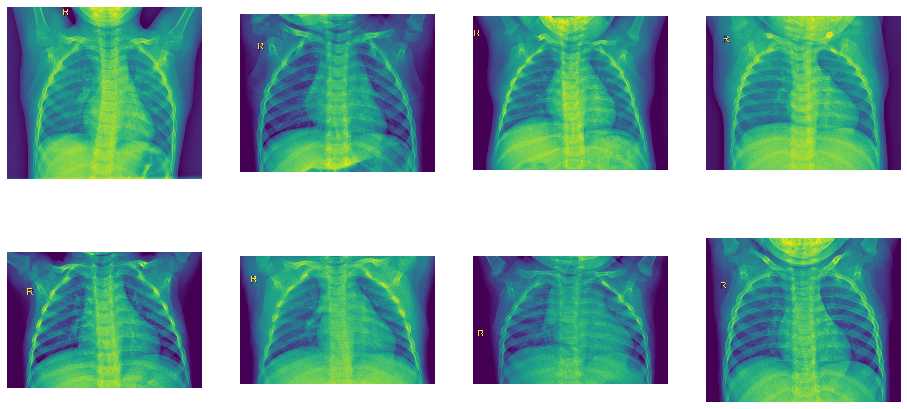

Showing some abnormal pictures...



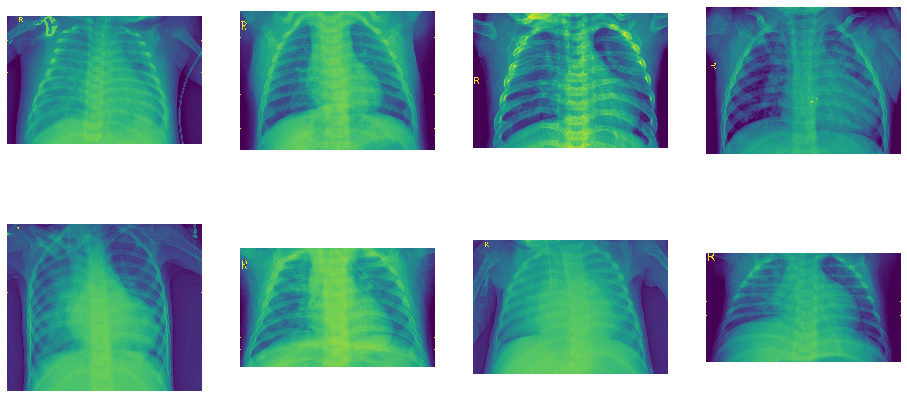

In [7]:
# Parameters for the graph. Output images in a 4x4 config. 
nrows = 4
ncols = 4

# index for iterating over images
pic_index = 0

fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

pic_index += 8
next_normal_pix = [os.path.join(normal_dir, fname)
                 for fname in train_normal_chest[pic_index-8:pic_index]]
next_abnormal_pix = [os.path.join(abnormal_dir, fname)
                    for fname in train_abnormal_chest[pic_index-8:pic_index]]

print("Showing some normal pictures...")
print()
for i, img_path in enumerate(next_normal_pix):
    # Set up subplot; subplot indices start at 1
    sp = plt.subplot(nrows, ncols, i + 1)
    sp.axis('Off') # Don't show axes (or gridlines)
    
    img = mpimg.imread(img_path)
    plt.imshow(img)
    
plt.show()

print("Showing some abnormal pictures...")
print()
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)
for i, img_path in enumerate(next_abnormal_pix):
    # Setup subplot; subplot indices start at 1
    sp = plt.subplot(nrows, ncols, i + 1)
    sp.axis('Off') # Don't show axes (or gridlines)
    
    img = mpimg.imread(img_path)
    plt.imshow(img)
    
plt.show()

### Building the ImageDataGenerator object

The class for ImageDataGenerator says "Generate batches of tensor image data with real-time data agumentation. Data will be looped over in batches"

Simply, it can be used to augment image data with a lot of built in preprocessing such as scaling, shifting, rotation, noise, whitening, ect. FOr now we just use the rescale attribute to scale the image tensor values between 0 and 1. 

The flow_from_directory method is super useful to pull image files one after another from specific directories. This method works by scanning top-level-directories where all sub-directories of ind classes can be stored seperately. The method automatically scans through all the sub-directories and sources the images along with their appropriate label. 

The other useful argument is the target_size which allows to resize the source images to uniform size of 200 x 200. No matter the original size of the image. 

We'll need to specify the batch_size since leaving it will default to 32.

When the code is ran Keras function scans through the top-level-directory and finds all image files and labels them automatically with the proper class based on the sub-directories they were located in. 

Image_files_on_disk -> ImageDataGenerator.flow_from_directory() -> In-memory data structure



In [8]:
batch_size = 163

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1/255)

# Flow training images in batches of 128 using train_datagen generator 
train_generator = train_datagen.flow_from_directory(
    'E:/chest_xray//train', # this is the source directory for training images
     target_size=(200,200), # All images will be resized 200x200
    batch_size=batch_size,
    # Specify the classes explicitly
    classes = ['NORMAL', 'PNEUMONIA'],
    # Since we use categorical_crossentropy loss, we need categorical labels
    class_mode ='categorical'
)

Found 5216 images belonging to 2 classes.


## Build the model

In [9]:
import tensorflow as tf

### Model architecture 

In [10]:
model = tf.keras.models.Sequential([
    # The first convultion
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(200, 200, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # The second convolution
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The third convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fourth convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fifth convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a dense layer
    tf.keras.layers.Flatten(),
    # 128 neuron in the fully-connected layer
    tf.keras.layers.Dense(128, activation='relu'),
    # 5 output neurons for 2 classes with the softmax activation
    tf.keras.layers.Dense(2, activation='softmax')
])

## Model Summary 

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 198, 198, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 99, 99, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 97, 97, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 48, 48, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 46, 46, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 21, 21, 64)        3

## Optimizer 

In [12]:
from tensorflow.keras.optimizers import RMSprop

model.compile(loss='categorical_crossentropy',
             optimizer=RMSprop(lr=0.001),
             metrics=['acc'])
             

## Total number of samples found 

We will see shortly where quality is used in training. 

In [13]:
total_sample = train_generator.n # finding the sample size
print(total_sample)

5216


## Training 

#### Fit using the fit_gererator method which utilizes the train_generator object

Since Python generator is generic it never stops and therefore will not know where a particular epoch ending and the next one starting so we have to specify the steps in a single epoch. The length of the total training sample divided by the batch size. 

batch_size is 163 which will give us 32 steps since our steps_per_epoch is int(total_sample/batch_size)

In [14]:
n_epochs = 30 # Run 30 times

In [15]:
history = model.fit_generator(
train_generator,
steps_per_epoch=int(total_sample/batch_size),
epochs=n_epochs,
verbose=1)

Epoch 1/30
32/32 [==============================] - 140s 4s/step - loss: 0.5936 - acc: 0.7166
Epoch 2/30
32/32 [==============================] - 121s 4s/step - loss: 0.4371 - acc: 0.8066
Epoch 3/30
32/32 [==============================] - 123s 4s/step - loss: 0.2860 - acc: 0.8877
Epoch 4/30
32/32 [==============================] - 91s 3s/step - loss: 0.2306 - acc: 0.9082
Epoch 5/30
32/32 [==============================] - 85s 3s/step - loss: 0.1954 - acc: 0.9247
Epoch 6/30
32/32 [==============================] - 84s 3s/step - loss: 0.1406 - acc: 0.9454
Epoch 7/30
32/32 [==============================] - 65s 2s/step - loss: 0.1398 - acc: 0.9434
Epoch 8/30
32/32 [==============================] - 55s 2s/step - loss: 0.1034 - acc: 0.9622
Epoch 9/30
32/32 [==============================] - 56s 2s/step - loss: 0.1005 - acc: 0.9615
Epoch 10/30
32/32 [==============================] - 56s 2s/step - loss: 0.0816 - acc: 0.9682
Epoch 11/30
32/32 [==============================] - 56s 2s/step -

### Plot the accuracy/loss over the progression of training(epochs)

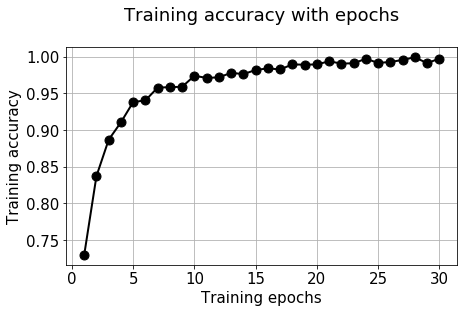

In [16]:
plt.figure(figsize=(7,4))
plt.plot([i+1 for i in range(n_epochs)],history.history['acc'], '-o',c='k',lw=2,markersize=9)
plt.grid(True)
plt.title("Training accuracy with epochs\n",fontsize=18)
plt.xlabel("Training epochs", fontsize=15)
plt.ylabel("Training accuracy",fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

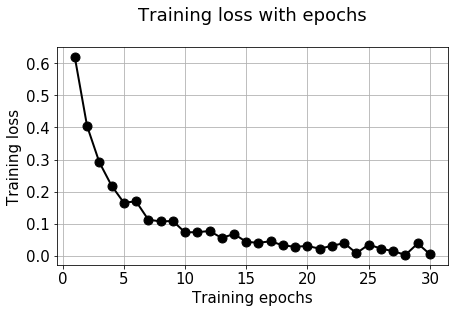

In [17]:
plt.figure(figsize=(7,4))
plt.plot([i+1 for i in range(n_epochs)],history.history['loss'],'-o',c='k',lw=2,markersize=9)
plt.grid(True)
plt.title("Training loss with epochs\n",fontsize=18)
plt.xlabel("Training epochs",fontsize=15)
plt.ylabel("Training loss",fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

The arguments that will be in the train_CNN function. 
* train_directory: Directory where the training images are stored in seperate folders. These folders should be named as per the classes.
* target_size: Target size for the training images. A tupe e.g. (200,200)
* classes: A Python list with classes  for which we want the training to happen.This forces the generator to choose files from the train_directory and not look at all the data. 
* batch_size: Batch size for training 
* num_epochs: Number of epochs for training 
* num_classes: Number of output classes to consider
* verbose: Verbosity levl of the training, passed onto the fit_generator method. 

In [1]:
def train_CNN(train_directory,target_size=(200,200), classes=None,
              batch_size=163,num_epochs=30,num_classes=2,verbose=0):
    """
    Trains a conv net for the peumonia dataset with a 2-class classifiction output
    Also provides suitable arguments for extending it to other similar apps
    
    Arguments:
            train_directory: The directory where the training images are stored in separate folders.
            These folders should be named as per the classes.
            target_size: Target size for the training images. A tuple e.g. (200,200)
            classes: if not specified, default to subdirectories 
            batch_size: Total # of sample size % by 32
            num_epochs: Number of epochs for training
            num_classes: Number of output classes to consider
            verbose: Verbosity level of the training, passed on to the `fit_generator` method
    Returns:
            A trained conv net model
    
    """
    from tensorflow.keras.preprocessing.image import ImageDataGenerator
    import tensorflow as tf
    from tensorflow.keras.optimizers import RMSprop
    import matplotlib.pyplot as plt
    import matplotlib.image as mpimg
    
    # ImageDataGenerator object instance with scaling
    train_datagen = ImageDataGenerator(rescale=1./255)

    # Flow training images in batches using the generator
    train_generator = train_datagen.flow_from_directory(
            train_directory,  # This is the source directory for training images
            target_size=target_size,  # All images will be resized to 200 x 200
            batch_size=batch_size,
            # Specify the classes explicitly
            #classes = classes,
            # Since we use categorical_crossentropy loss, we need categorical labels
            class_mode='categorical')
    
    input_shape = tuple(list(target_size)+[3])
    
    # Model architecture
    model = tf.keras.models.Sequential([
    # The first convultion
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=input_shape),
    tf.keras.layers.MaxPooling2D(2, 2),
    # The second convolution
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The third convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fourth convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fifth convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a dense layer
    tf.keras.layers.Flatten(),
    # 128 neuron in the fully-connected layer
    tf.keras.layers.Dense(128, activation='relu'),
    # 5 output neurons for 2 classes with the softmax activation
    tf.keras.layers.Dense(2, activation='softmax')
])

    # Model Summary
    model.summary()
    
    # Optimizer and compilation
    model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(lr=0.001),
              metrics=['acc'])
    
    # Total sample count
    total_sample=train_generator.n
    
    print('\n')    
    # Training
    print("Training...")
    model.fit_generator(
        train_generator, 
        steps_per_epoch=int(total_sample/batch_size),  
        epochs=num_epochs,
        verbose=verbose)
    
    return model

#### So far we have been able to utilize Keras ImageDataGenerator class and fit_generator method to pull images automatically from a single directory, label them, resize and scale them. THen flow them one by one (in batches) for training neural network. 



# Test
Now test our train_CNN function by supplying a folder/directory name and getting back a trained model which can be used for predictions. 

We are able to get a fully trained CNN model with 2 lines of code

In [2]:
train_directory = "E:/chest_xray//train"

In [3]:
trained_model=train_CNN(train_directory=train_directory,classes=['NORMAL','PNEUMONIA'],
                        num_epochs=28,num_classes=2,verbose=1)

Found 5216 images belonging to 2 classes.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 198, 198, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 99, 99, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 97, 97, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 48, 48, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 46, 46, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_3 (Conv

# Test Directory

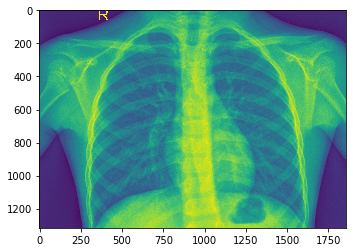

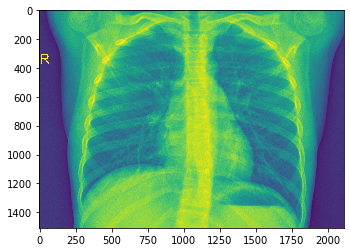

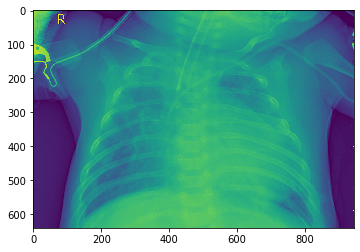

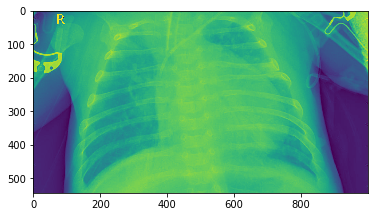

In [4]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

img_path = 'E:/chest_xray//test//NORMAL//IM-0001-0001.jpeg'
img_norm = mpimg.imread(img_path)
plt.imshow(img_norm)
plt.show()

img_path = 'E:/chest_xray/test/NORMAL/IM-0003-0001.jpeg'
img_norm = mpimg.imread(img_path)
plt.imshow(img_norm)
plt.show()

img_path = 'E:/chest_xray/test/PNEUMONIA/person1_virus_6.jpeg'
img_pneu = mpimg.imread(img_path)
plt.imshow(img_pneu)
plt.show()

img_path = 'E:/chest_xray/test/PNEUMONIA/person1_virus_7.jpeg'
img_pneu = mpimg.imread(img_path)
plt.imshow(img_pneu)
plt.show()

In [22]:
from tensorflow.keras.preprocessing.image import load_img as K_load_img, img_to_array as K_img_to_array
from PIL import Image
import numpy as np

img_path1='E:/chest_xray/test/NORMAL/IM-0001-0001.jpeg'
img_1 = K_load_img(img_path1)
array2 = K_img_to_array(img_1).astype(np.uint8)
print('#2' + str(array2.shape))
img_3 = Image.fromarray(array2, 'RGB').resize((200,200))
array4 = np.array(img_3)
array4 = np.expand_dims(array4, axis=0)
print('#4' + str(array4.shape))



#2(1317, 1857, 3)
#4(1, 200, 200, 3)


In [23]:
import tensorflow as tf 

image_path1 = 'E:/chest_xray/test/NORMAL/IM-0003-0001.jpeg'
image_1 = K_load_img(image_path1)
img_array = K_img_to_array(image_1).astype(np.float32)
#img_array = tf.(img_array, tf.float32)
print('#3' + str(img_array.shape))
image_3 = Image.fromarray(img_array, 'RGB').resize((200,200))
array_5 = np.array(image_3)
array_5 = np.expand_dims(array_5, axis=0)
print('#5' + str(array_5.shape))


#3(1509, 2111, 3)
#5(1, 200, 200, 3)


In [9]:
import numpy as np
from tensorflow.keras.preprocessing import image

IMG_WIDTH, IMG_HEIGHT = 200, 200
img_n1 = image.load_img('E:/chest_xray//test//NORMAL//IM-0001-0001.jpeg', target_size = (IMG_WIDTH, IMG_HEIGHT))
img_n1 = image.img_to_array(img_n1)
img_n1 = np.expand_dims(img_n1, axis = 0)

trained_model.predict(img_n1)

array([[1., 0.]], dtype=float32)

In [10]:
IMG_WIDTH, IMG_HEIGHT = 200, 200
img_p1 = image.load_img('E:/chest_xray/test/PNEUMONIA/person1_virus_6.jpeg', target_size = (IMG_WIDTH, IMG_HEIGHT))
img_p1 = image.img_to_array(img_p1)
img_p1 = np.expand_dims(img_p1, axis = 0)

trained_model.predict(img_p1)

array([[0., 1.]], dtype=float32)

### It predicts img_n1 as class 1(NORMAL) and img_p1 with class 2(PNEUMONIA). 